In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.stats import linregress

In [2]:
class Leath:
    def __init__(self, N=80, p=.6, animate=False):
        self.N = N
        self.p = p
        self.no_particles = 0
        self.perimeter = {}
        self.cluster = {}
        self.world = np.zeros((self.N, self.N), dtype=np.int8)
        self.reached_end = False
        self.stopped_growing = False
        self.seed_cluster()

        self.animate = animate
        if self.animate:
            self.fig, self.ax = plt.subplots()
            self.im = self.ax.imshow(self.world, cmap='GnBu')

    def seed_cluster(self):
        pt = (self.N // 2, self.N // 2)
        self.cluster[pt] = True
        self.add_perimeter(pt)
        self.world[pt] = 1
        self.no_particles = 1

    def reset(self):
        self.perimeter = {}
        self.cluster = {}
        self.world = np.zeros((self.N, self.N), dtype=np.int8)
        self.stopped_growing = False
        self.reached_end = False
        self.seed_cluster()
        if self.animate:
            self.fig, self.ax = plt.subplots()
            self.im = self.ax.imshow(self.world, cmap='GnBu')

    def simulate(self):
        self.reset()
        self.seed_cluster()
        while not self.stopped_growing:
            self.grow_cluster()
        return

    def add_perimeter(self, pt):
        """
        Given a point pt (tuple), add to a perimeter all 4 nearest neighbors that are not already in the cluster.
        """
        # Create list of four nearest neighbors
        nn = [(pt[0] + 1, pt[1]), (pt[0] - 1, pt[1]), (pt[0], pt[1] + 1), (pt[0], pt[1] - 1)]

        # Iterate through the points of the nearest neighbors and add them to the perimeter
        for p in nn:
            if p not in self.cluster and p not in self.perimeter:
                self.perimeter[p] = True

    def grow_cluster(self):
        """
        Iterate through each point in perimeter if uniform random [0,1] is less than p add perimeter point to cluster.
        Else mark point as inaccessible.
        Do something to keep cluster from leaving domain.
        """
        # Need a new list to store cluster points
        new_cluster_pts = []

        # Loop through the active points in the perimeter, add the point the cluster with probability p
        active_perimeter = [k for k, v in self.perimeter.items() if bool(v)]
        for pt in active_perimeter:
            if self.p >= np.random.rand():
                new_cluster_pts.append(pt)
            else:
                # self.cluster[pt] = False
                self.perimeter[pt] = False

        # Check if there are no new points being added to the cluster
        if len(new_cluster_pts) == 0:
            self.stopped_growing = True
            return False

        # Loop through the new cluster points and add their nearest neighbors to the perimeter
        for pt in new_cluster_pts:
            if pt[0] in range(0, self.N) and pt[1] in range(0, self.N):
                self.cluster[pt] = True
                self.perimeter[pt] = False
                self.no_particles += 1
                self.world[pt[1], pt[0]] = 1
                self.add_perimeter(pt)
            else:
                self.reached_end = True
                return False

    def animate_leath(self, display=False):
        plt.axis('off')
        anim = FuncAnimation(self.fig, self._animate, interval=100, frames=1000,
                             repeat=False)
        if display:
            plt.show()
        return anim

    def _animate(self, i):

        if leath.stopped_growing or leath.reached_end:
            return
        else:
            self.grow_cluster()

        self.im.set_data(self.world)
        self.ax.set_title(f'Leath Cluster at {i} Iterations')

    def distance_from_center_of_mass(self):
        # Loop through points in dictionary and create np array
        list_of_pts = list()
        for pt in self.cluster.keys():
            list_of_pts.append(pt)
        pts = np.array(list_of_pts, np.float32)

        # Compute center of mass adjusted distances
        cm_pts = pts - np.sum(pts, 0) / self.no_particles
        r = np.sqrt(np.square(cm_pts[:, 0]) + np.square(cm_pts[:, 1]))

        return r

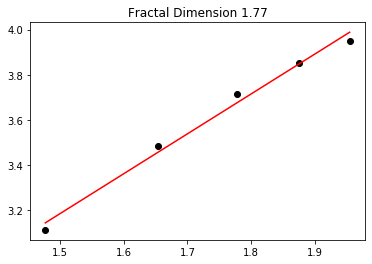

In [4]:
# Values for leath cluster
N = 300
p = 0.5927

# Initialize a leath cluster
leath = Leath(N, p=p, animate=False)

# Initialize fit and simulation values
max_clusters = 5
cluster_no = 0
no_bins = 5
bin_count = np.zeros(no_bins, dtype=np.int32)
bin_edges = np.zeros([max_clusters, no_bins+1], dtype=np.float32)
min_size = 0.15 * N/2
max_size = 0.65 * N/2

# Grow total_clusters Different Clusters of lattice size 300 with at least N_min particles
while cluster_no < max_clusters:
    # run a Leath simulation
    leath.simulate()
    while not leath.reached_end:
        leath.simulate()
    radii = leath.distance_from_center_of_mass()
    cnt, bin_edges[cluster_no, :] = np.histogram(radii, bins=no_bins, range=(min_size, max_size))
    bin_count += np.cumsum(cnt)

    cluster_no += 1

# Take the average count and bin centers across all clusters
avg_bin_count = bin_count / max_clusters
avg_bin_edge = np.mean(bin_edges, 0)
avg_bin_mid = (avg_bin_edge[1:] + avg_bin_edge[0:-1]) / 2

# Fit a line to the r and M(r) data
fit = linregress(np.log10(avg_bin_mid), np.log10(avg_bin_count))
x = np.linspace(np.log10(avg_bin_mid[0]), np.log10((avg_bin_mid[-1])), 1000)
y = fit.slope * x + fit.intercept

# Plot r vs. M(r), as well as slope/intercept of the fitted line
fig = plt.figure()
im = plt.plot(np.log10(avg_bin_mid), np.log10(avg_bin_count), 'ko', x, y, 'r-')
plt.title(f'Fractal Dimension {fit.slope:4.2f}')
plt.show()